In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as confusion_matrix
import glob
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
#file path and format for dataset
pathname ='data/'
file_format = '*.csv'

#function to load and merge csv files for dataset
def load_merge_dataset(pathname,file_format):
    csv_files = Path(pathname).glob(file_format)
    pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True).to_csv("combined_slice_dataset.csv", index=False)  
    df=pd.read_csv("combined_slice_dataset.csv")
    df = df.drop(df.filter(regex='^Unnamed').columns,axis=1)
    df.columns = df.columns.str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.replace(' ','_').str.replace('%','pct').str.lower()
    return df

df=load_merge_dataset(pathname,file_format)
df=df.fillna(0)
df['slice_id'].unique()
df.shape



(6290, 31)

In [3]:
def convert_timestamp_to_networkLoad(timestamp):
    dt =pd.to_datetime(timestamp,unit='ms',utc=True).tz_convert("Europe/Rome")
    hour = dt.hour
    if hour >=17 and hour <=21:
        load = 'peak'
    elif hour >=0 and hour<7:
        load = 'night'
    else:
        load = 'off-peak'
    return hour,load

df[['hour','network_load']] = df['timestamp'].apply(convert_timestamp_to_networkLoad).apply(pd.Series)

  # 1. Reliability Margin (How conservative is the MCS?)
df['mcs_sinr_ratio'] = df['dl_mcs'] / (df['ul_sinr'] + 1)
    
    # 2. Grant Satisfaction (Is the scheduler prioritizing this user?)
df['grant_ratio'] = df['sum_granted_prbs'] / (df['sum_requested_prbs'] + 1e-6)
    
    # 3. Efficiency (Throughput per PRB)
df['prb_efficiency'] = df['tx_brate_downlink_mbps'] / (df['sum_granted_prbs'] + 1e-6)
    
    # 4. Latency Signature (Buffer vs Throughput)
df['latency_proxy'] = df['dl_buffer_bytes'] / (df['tx_brate_downlink_mbps'] + 0.1)

column_names = [ 'timestamp','num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id',
       'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs',
       'dl_n_samples', 'dl_buffer_bytes', 'tx_brate_downlink_mbps',
       'tx_pkts_downlink', 'tx_errors_downlink_pct', 'dl_cqi', 'ul_mcs',
       'ul_n_samples', 'ul_buffer_bytes', 'rx_brate_uplink_mbps',
       'rx_pkts_uplink', 'rx_errors_uplink_pct', 'ul_rssi', 'ul_sinr', 'phr',
       'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n',
       'ul_turbo_iters','hour','network_load','mcs_sinr_ratio', 'grant_ratio',
       'prb_efficiency', 'latency_proxy']

for col in column_names:
    print(col,"  ",df[col].unique())




timestamp    [1617070528226 1617070528476 1617070528726 ... 1617071053475 1617071053726
 1617071053975]
num_ues    [4 3 2 6 9 7 5]
imsi    [1010123456004 1010123456002 1010123456003]
rnti    [73 82 77]
slicing_enabled    [1]
slice_id    [1 2 0]
slice_prb    [39  5  6]
power_multiplier    [1]
scheduling_policy    [0]
dl_mcs    [ 3.29032  0.       9.      ... 12.5199  16.4492  14.0089 ]
dl_n_samples    [ 31   3   0  17  72  56  45  22  36  42  34  21  44  52  37  30  33  53
  19  40  28  26  55  35  23  39  38  43  32  25  60  47  20  27  24  15
  50  51  41  54  29  48  59  49  61  16  63  46  10  58  65  13  18  68
  69  62  57  66  12  71   6  67  79  76  70  64   2  73  14   7  80  82
  89   8  77 127 125 166 244 159 106  99 130 200 147 104 194 177 186 136
 123 133 122 232 121 103 128 169 139  93 226 171 168 185 255 245 218  95
 144 153 152 161  98 105 227 170 135 112 179 180 258 117 111 176 141 129
 165 110 164 181 190 146 301 253 233 351 257 173 209 116 172  96 118 302
 217 155 276

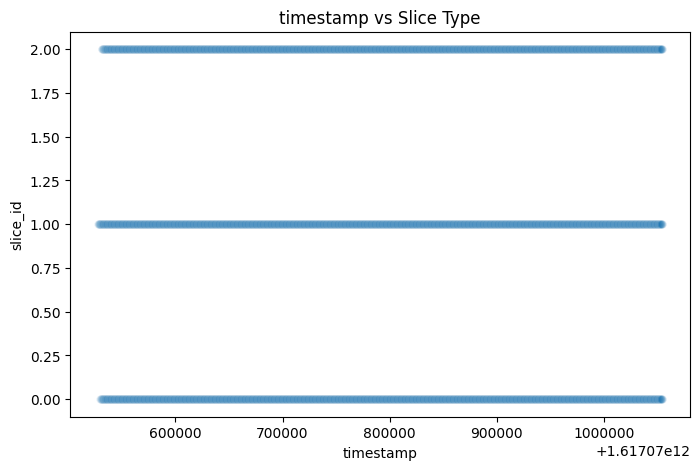

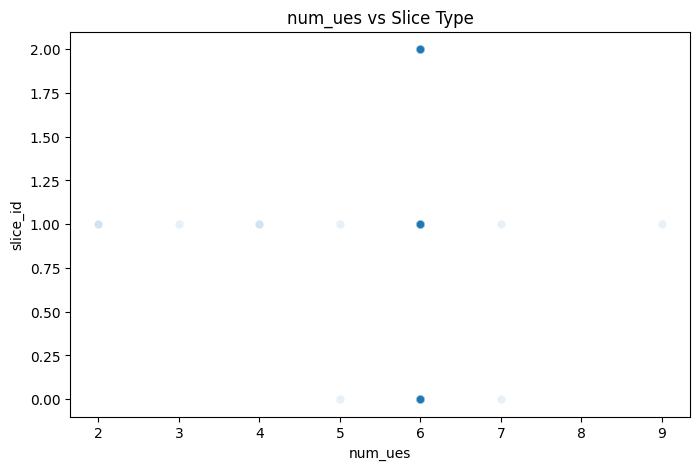

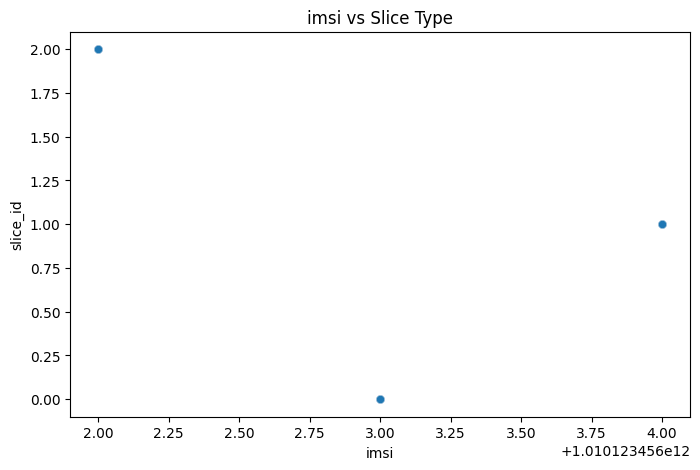

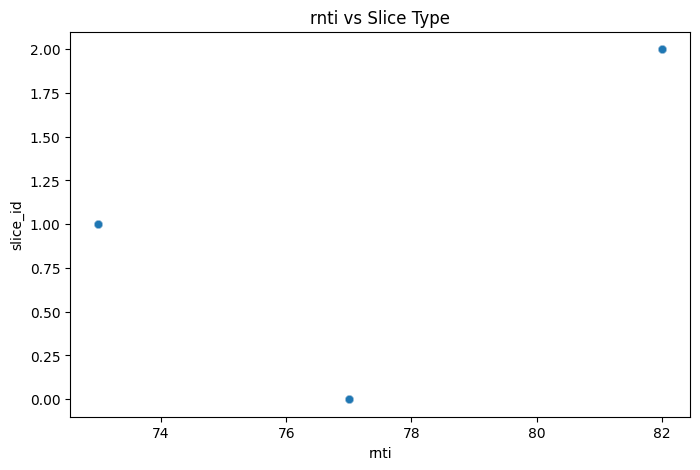

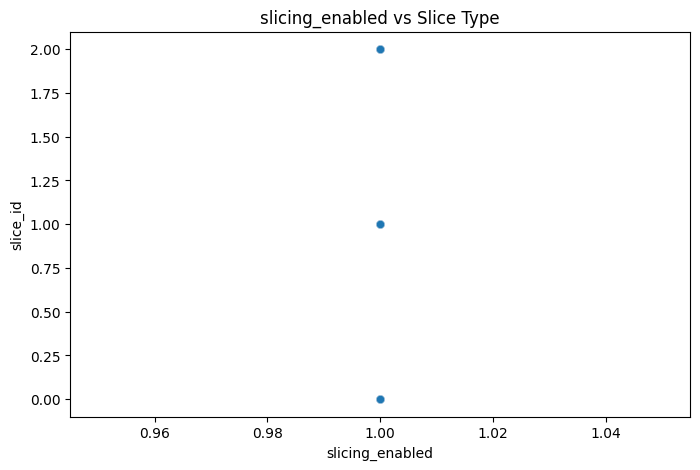

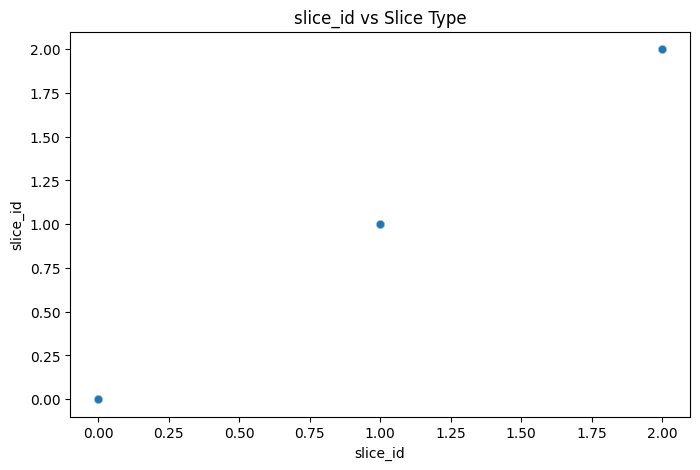

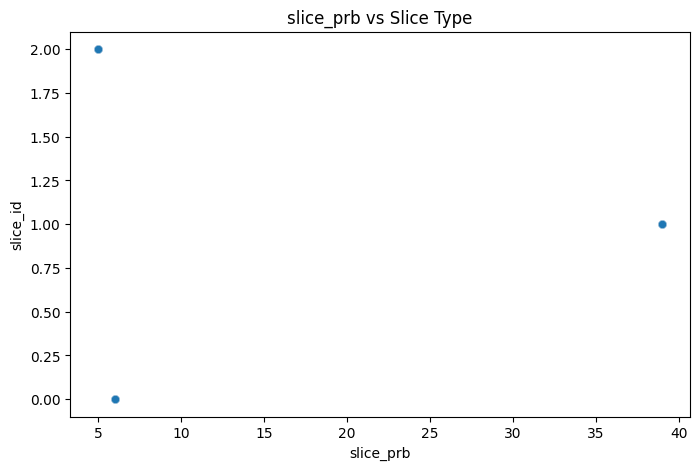

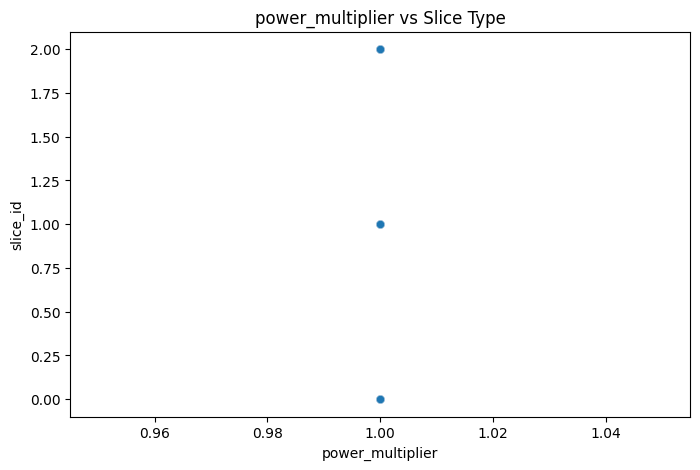

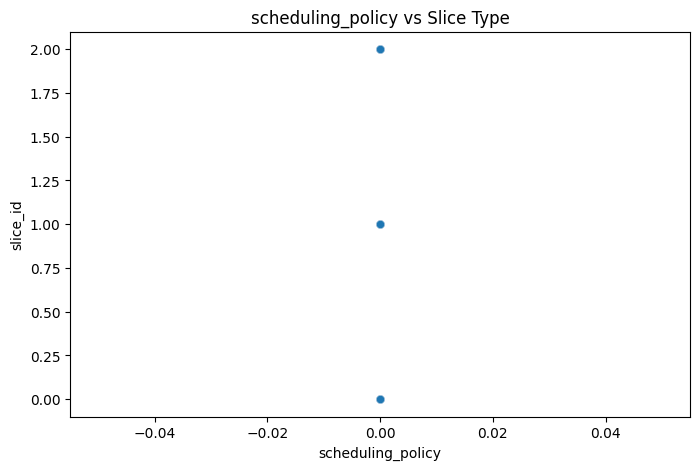

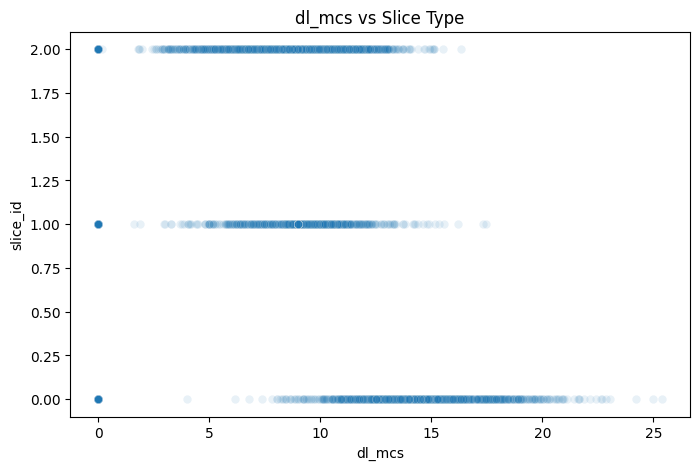

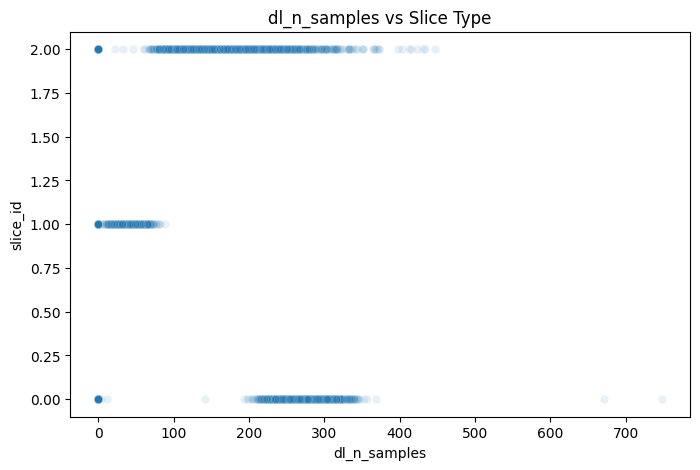

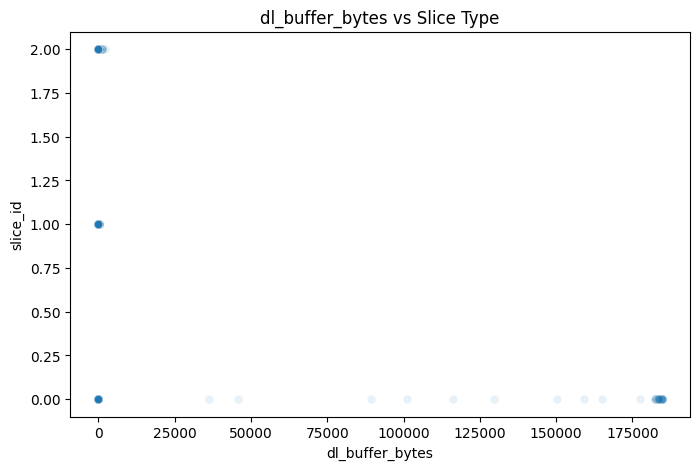

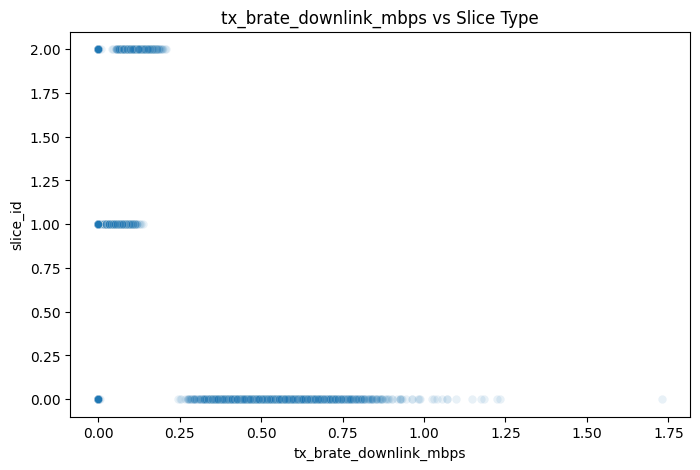

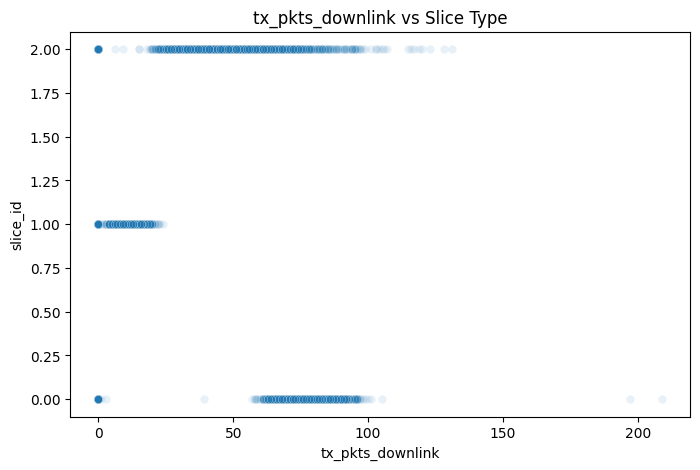

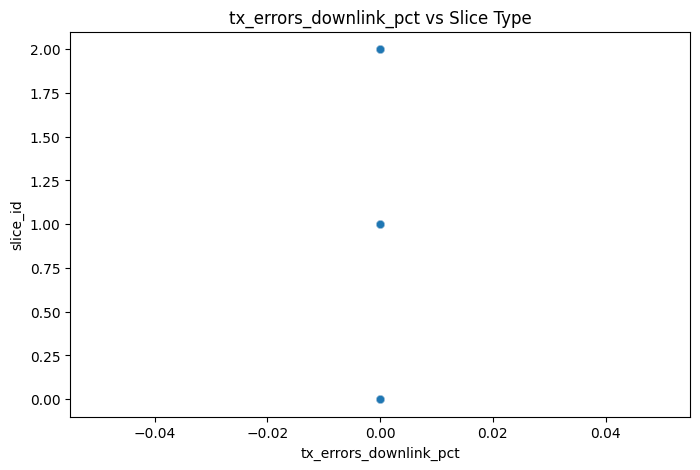

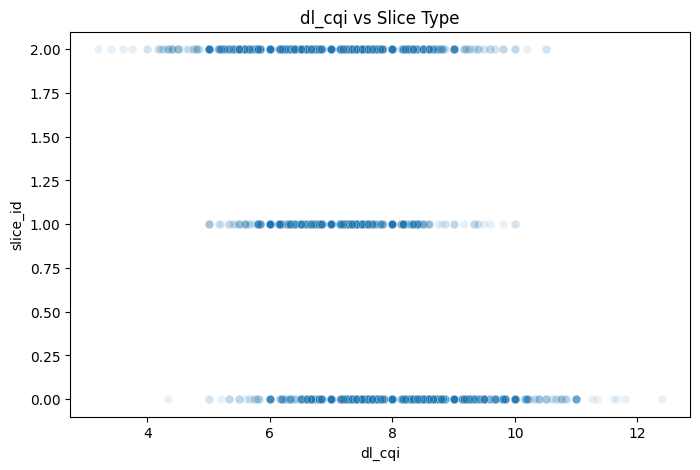

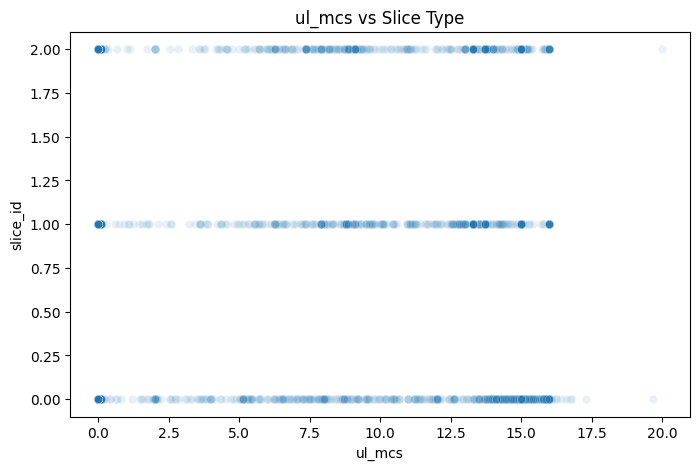

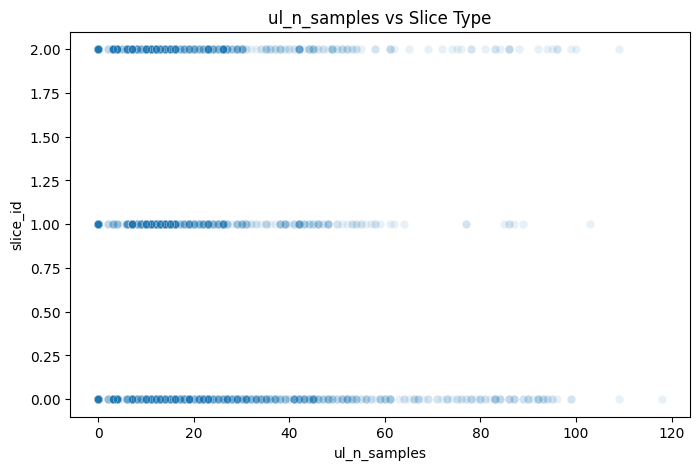

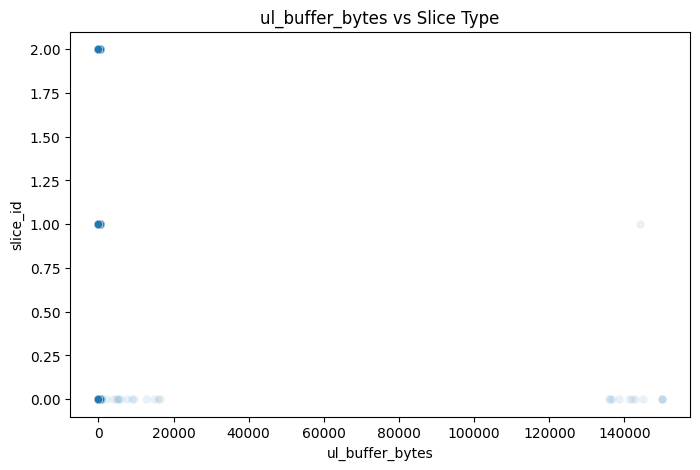

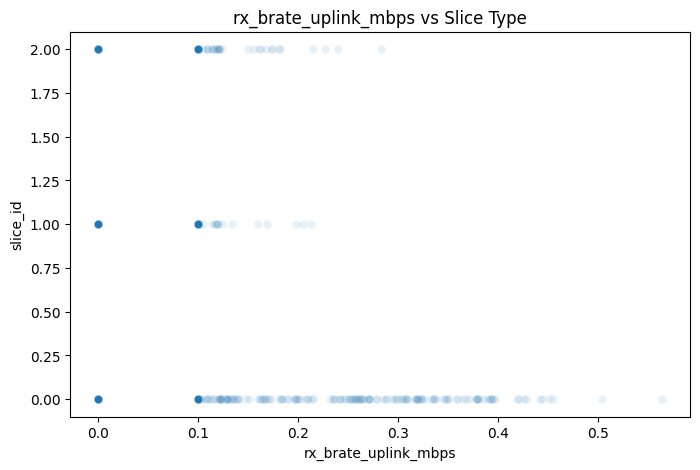

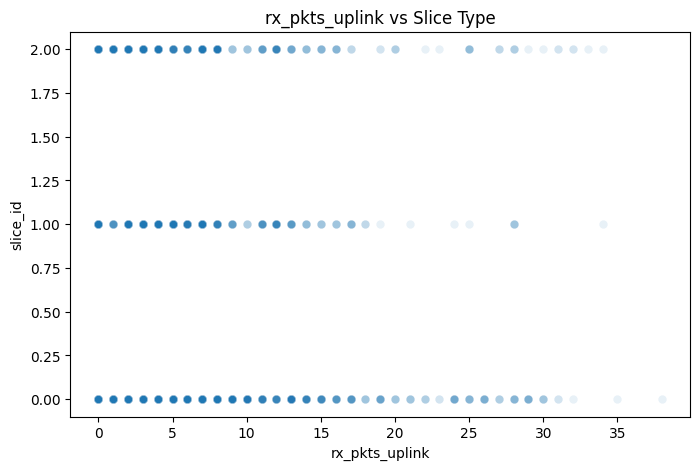

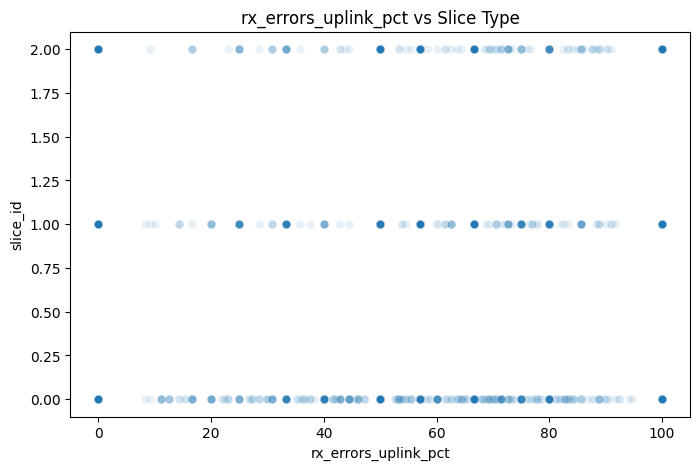

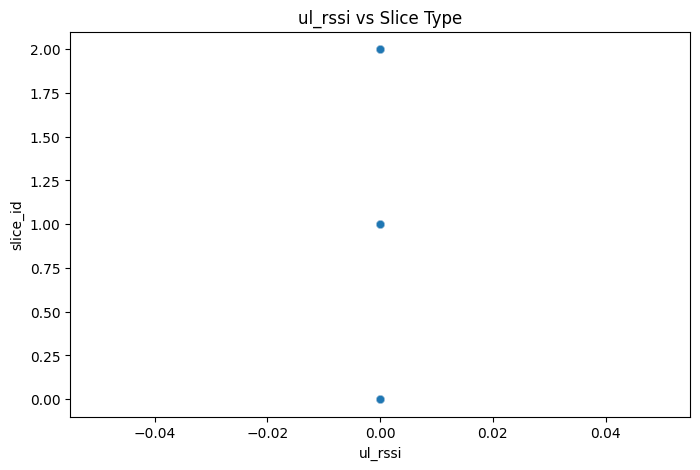

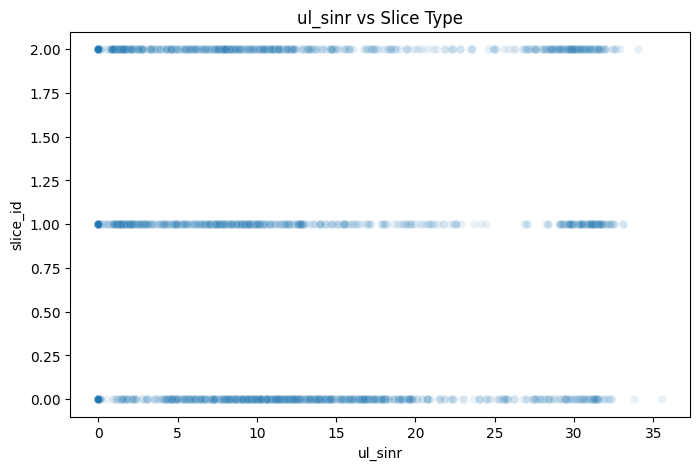

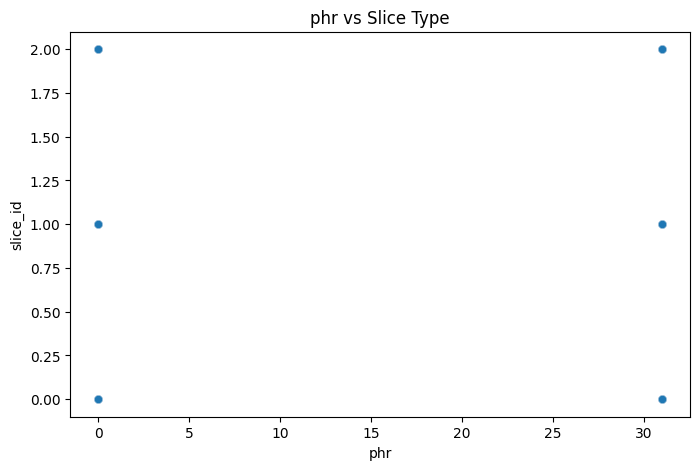

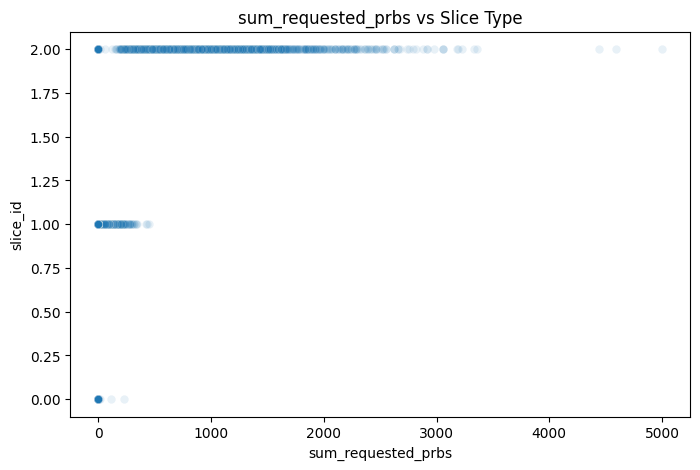

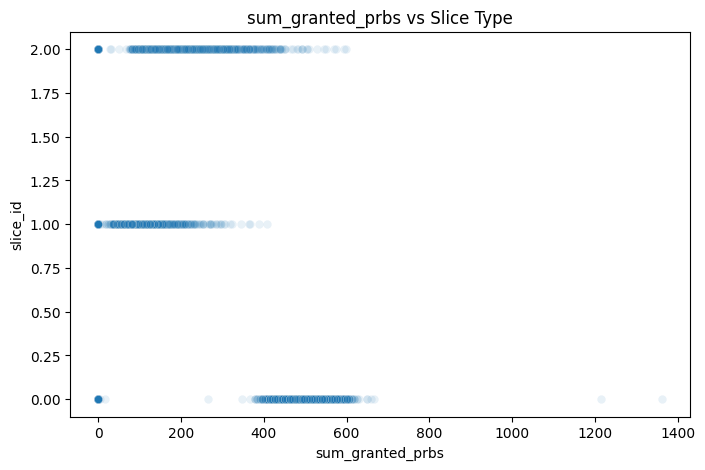

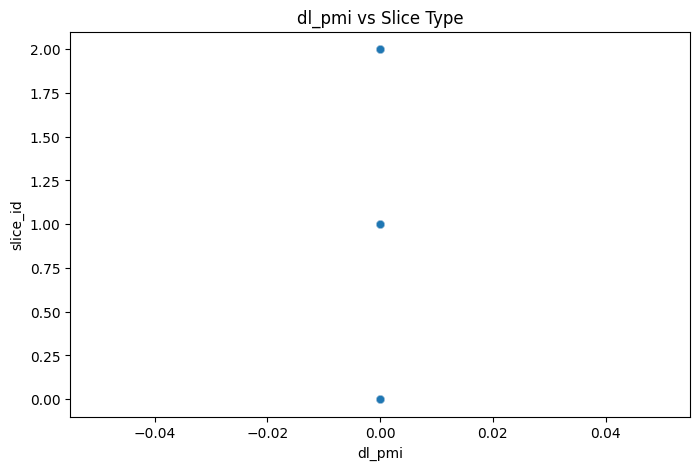

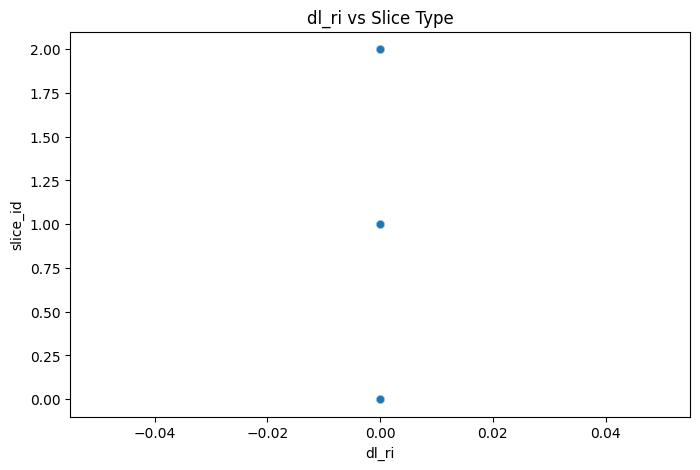

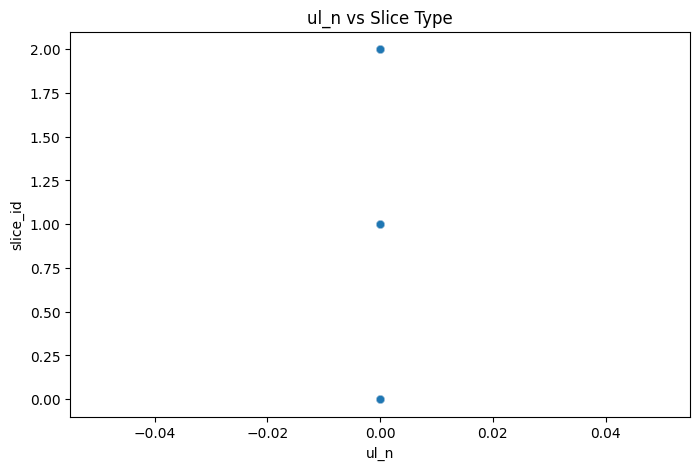

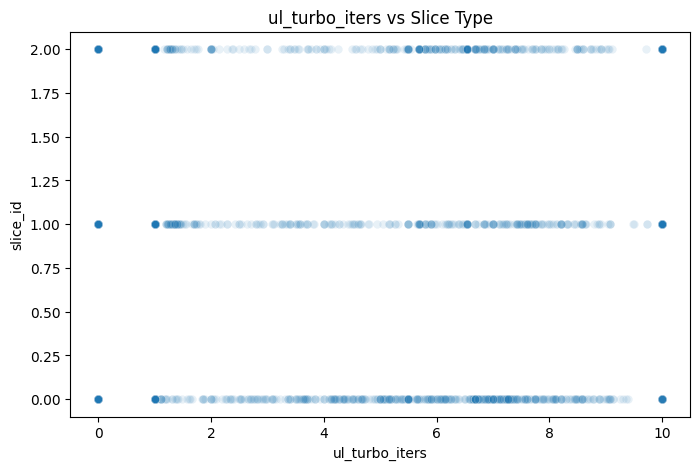

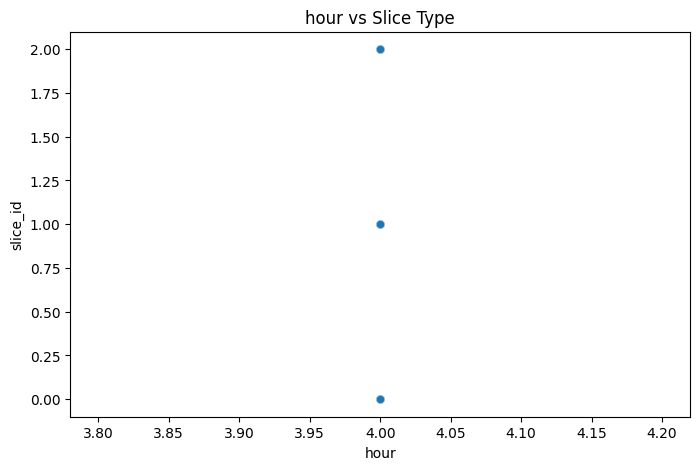

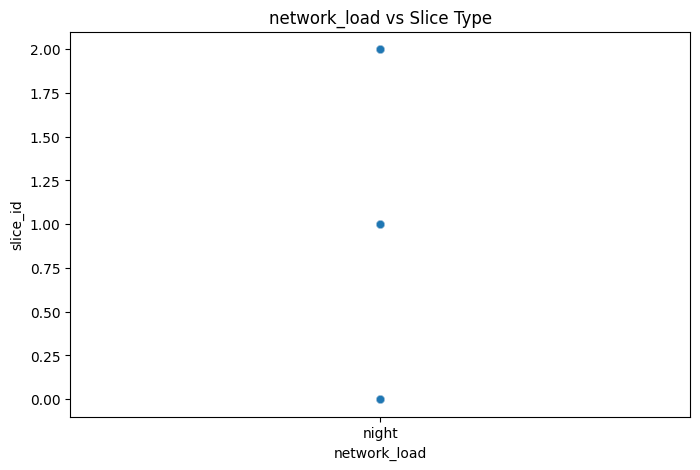

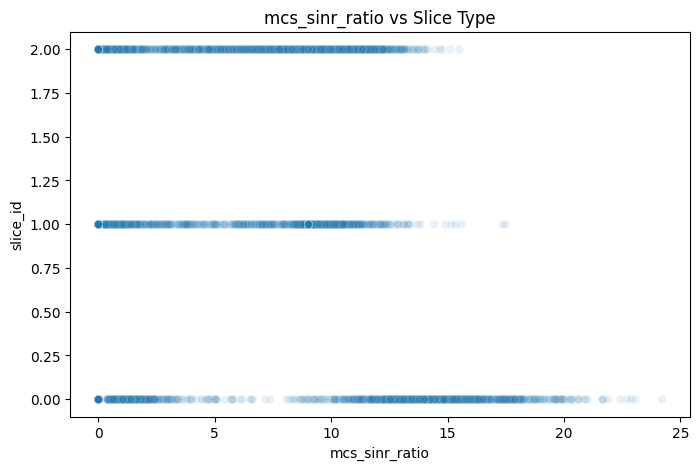

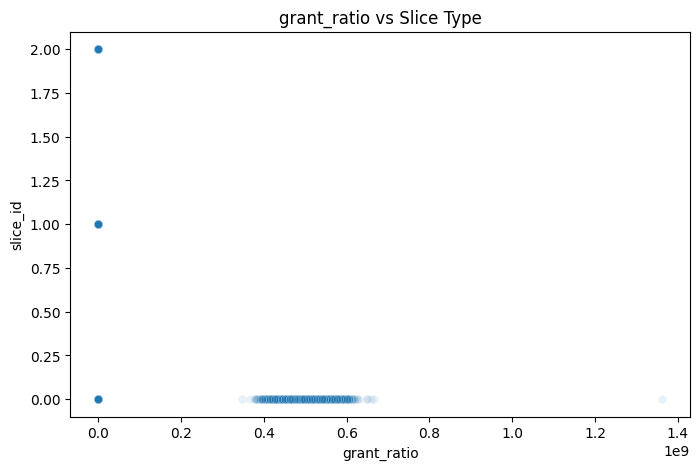

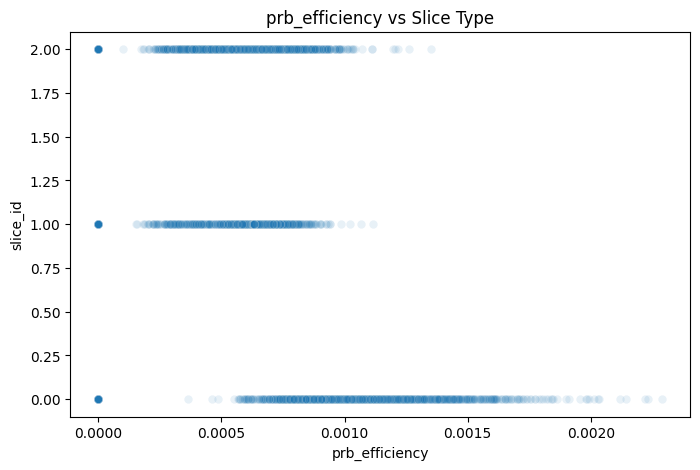

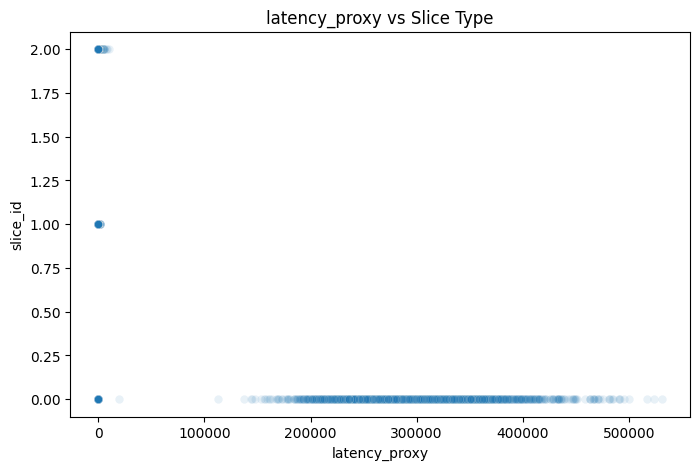

In [4]:
for col in column_names:
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        data=df,
        x=col,
        y=df.slice_id,
        alpha=0.1
    )
    #plt.xscale(col)
    plt.title(f"{col} vs Slice Type")
    plt.show()





In [5]:
df['network_load'].unique()



array(['night'], dtype=object)

Let's check if the dataset is balanced across slice types.

In [6]:
def check_classimbalance():
    class_imbalance_ratio = np.round(df.slice_id.value_counts().max()/df.slice_id.value_counts().min(),3)
    if(class_imbalance_ratio<2):
        print("Class is balanced,Imbalance Ratio : ", class_imbalance_ratio) 
    else:
        print("class is imbalanced,Imbalance ratio : ",class_imbalance_ratio) 

check_classimbalance()
def check_duplicates_in_dataset():
    duplicated_record_count = df.duplicated().sum()
    if(duplicated_record_count>0):
        print("Number of duplicates is ",duplicated_record_count)
        df.drop_duplicates()
        print("Duplicated records are successfully dropped")
    else:
        print("No duplicate records found as the duplicated record count is ",duplicated_record_count)

check_duplicates_in_dataset()

Class is balanced,Imbalance Ratio :  1.007
No duplicate records found as the duplicated record count is  0


Null check on columns - done . There are no null values in the dataset.
There are no duplicated values in the dataset.

(3774, 37)
(1258, 37)
(1258, 37)
slice_id
1    0.334499
0    0.333227
2    0.332273
Name: proportion, dtype: float64
slice_id
0    0.337573
1    0.334923
2    0.327504
Name: proportion, dtype: float64
slice_id
2    0.344992
0    0.331479
1    0.323529
Name: proportion, dtype: float64
slice_id
1    0.344197
2    0.333863
0    0.321940
Name: proportion, dtype: float64
Index(['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id',
       'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs',
       'dl_n_samples', 'dl_buffer_bytes', 'tx_brate_downlink_mbps',
       'tx_pkts_downlink', 'tx_errors_downlink_pct', 'dl_cqi', 'ul_mcs',
       'ul_n_samples', 'ul_buffer_bytes', 'rx_brate_uplink_mbps',
       'rx_pkts_uplink', 'rx_errors_uplink_pct', 'ul_rssi', 'ul_sinr', 'phr',
       'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n',
       'ul_turbo_iters', 'hour', 'mcs_sinr_ratio', 'grant_ratio',
       'prb_efficiency', 'latency_proxy'],
      dtype=

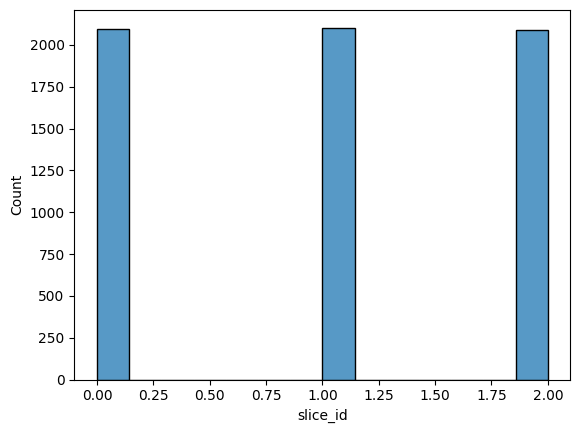

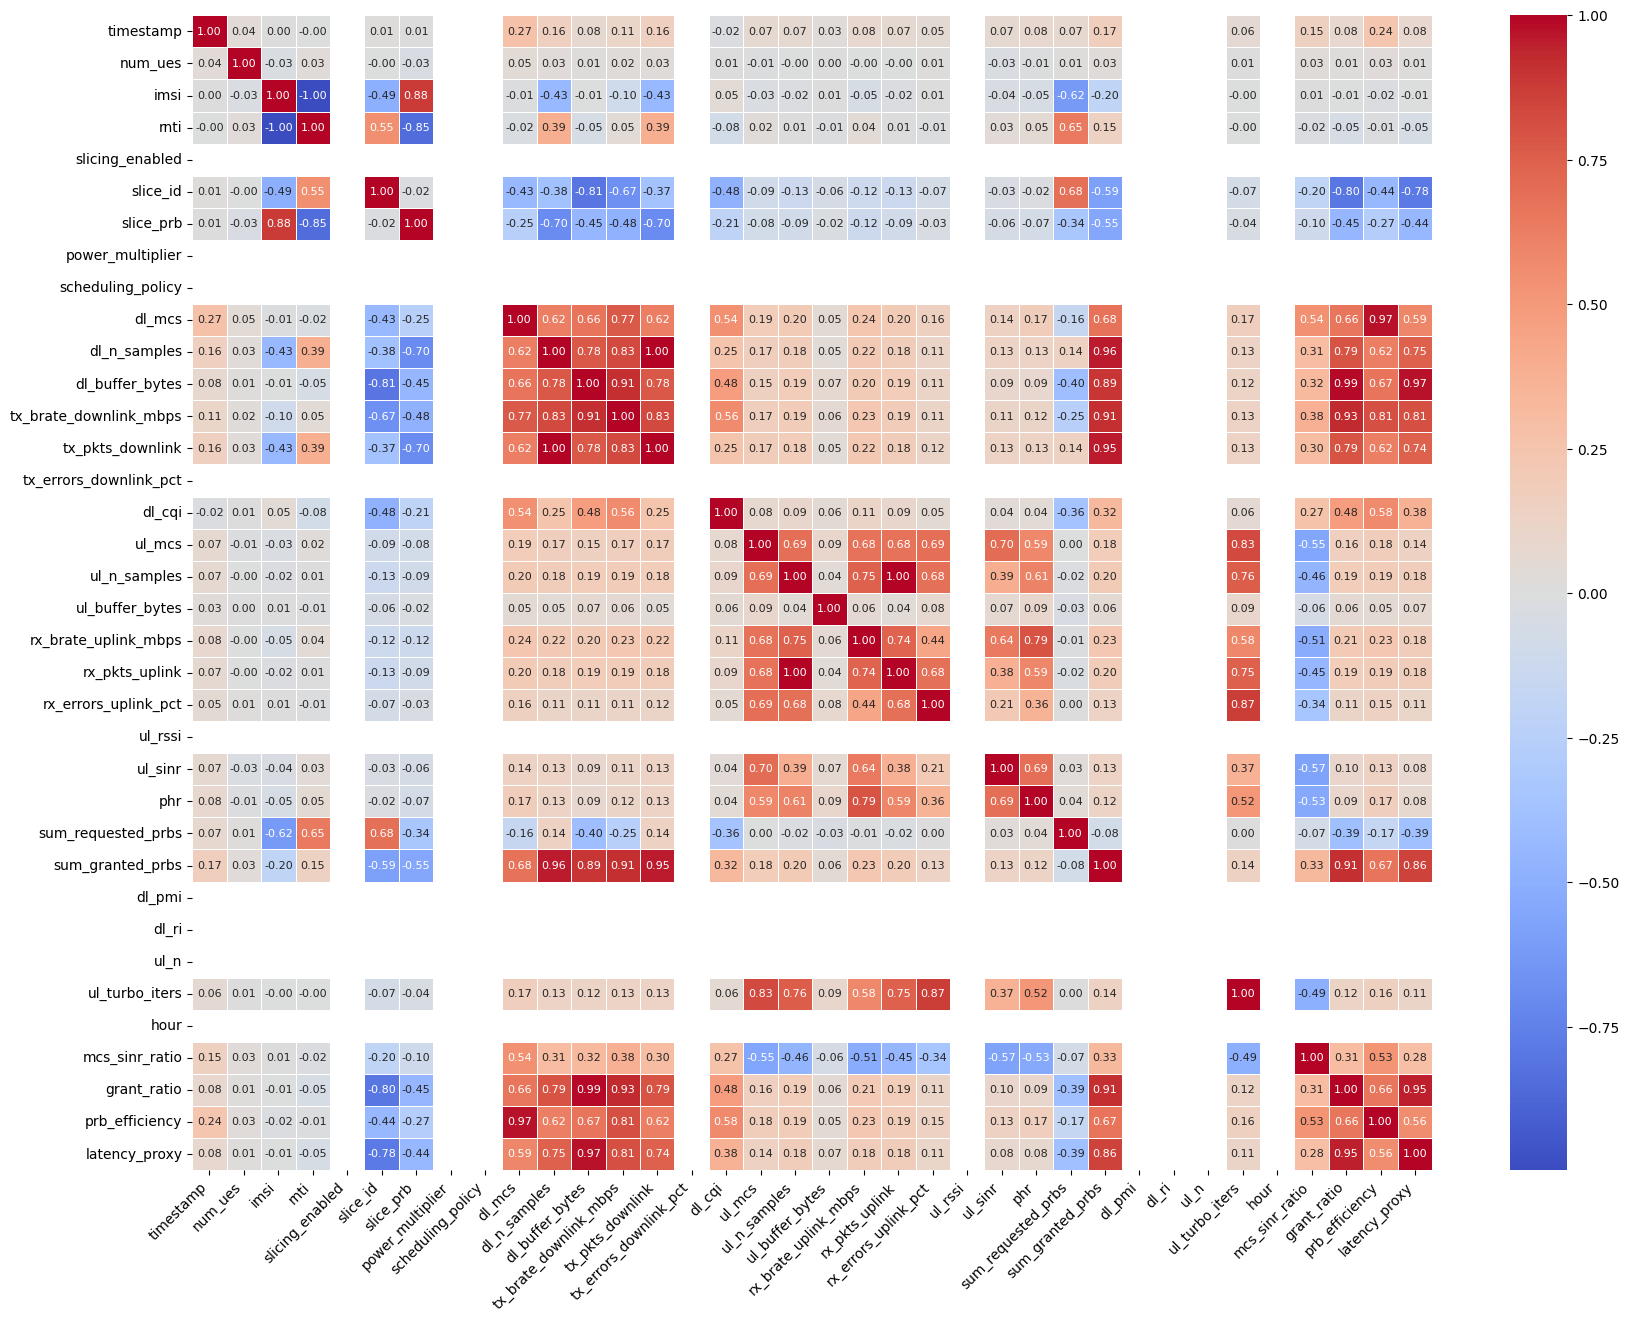

In [7]:
df_fulltrain , df_test= train_test_split(df,test_size=0.2,random_state=42)
df_train,df_val=train_test_split(df_fulltrain,test_size=0.25,random_state=42)
df_fulltrain = df_fulltrain.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

y_fulltrain = df_fulltrain['slice_id'].values
y_train = df_train['slice_id'].values
y_val = df_val['slice_id'].values
y_test = df_test['slice_id'].values

print(df["slice_id"].value_counts(normalize=True))
print(df_train["slice_id"].value_counts(normalize=True))
print(df_val["slice_id"].value_counts(normalize=True))
print(df_test["slice_id"].value_counts(normalize=True))
sns.histplot(df.slice_id)

# Plot the correlation matrix as a heatmap

numerical_columns = df.select_dtypes(include=[np.number]).columns
print(numerical_columns)
plt.figure(figsize=(20, 15)) # Make the canvas much larger
sns.heatmap(
    df_train[numerical_columns].corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    annot_kws={"size": 8},   # Smaller font for the numbers
    linewidths=0.5
)
plt.xticks(rotation=45, ha='right', fontsize=10) # Tilt labels for better fit
plt.yticks(fontsize=10)
plt.show()


In [8]:
unique_counts=df.nunique()
static_cols =unique_counts[unique_counts<=1].index.tolist()
print(static_cols)
# Identify "quasi-static" columns (e.g., less than 0.1% variation)
quasi_static_cols = [col for col in df.columns if (df[col].nunique() / len(df)) < 0.001]
print(quasi_static_cols)

['slicing_enabled', 'power_multiplier', 'scheduling_policy', 'tx_errors_downlink_pct', 'ul_rssi', 'dl_pmi', 'dl_ri', 'ul_n', 'hour', 'network_load']
['imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'tx_errors_downlink_pct', 'ul_rssi', 'phr', 'dl_pmi', 'dl_ri', 'ul_n', 'hour', 'network_load']


Let's split the dataset into training and testing sets.

In [9]:
def remove_static_columns_from_dataset(column_names):
    for col in column_names:
        del df_train[col]
        del df_fulltrain[col]
        del df_val[col]
        del df_test[col]

columns_to_keep = ['dl_mcs', 'ul_sinr', 'tx_brate_downlink_mbps', 'dl_buffer_bytes','ul_turbo_iters', 'dl_cqi',
       'ul_n_samples','network_load']

column_names = [ 'timestamp','num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id',
       'slice_prb', 'power_multiplier', 'scheduling_policy', 
         'dl_n_samples', 
        'tx_errors_downlink_pct', 'ul_mcs', 'ul_buffer_bytes', 'rx_brate_uplink_mbps',
       'rx_pkts_uplink', 'rx_errors_uplink_pct', 'ul_rssi',  'phr',
       'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n','tx_pkts_downlink','hour'
       ]
remove_static_columns_from_dataset(column_names)

In [10]:
df["hour"].value_counts().sort_index()


hour
4    6290
Name: count, dtype: int64

In [11]:
# Quick check for static features
def check_static_features(df):
    static_cols = []
    for col in df.columns:
        if df[col].nunique() == 1:
            static_cols.append(col)
            print(f"Static: {col} = {df[col].iloc[0]}")
    return static_cols

# Check variance
def check_low_variance(df, threshold=0.01):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    low_var = []
    for col in numeric_cols:
        variance = df[col].var()
        if variance < threshold:
            low_var.append(col)
            print(f"Low variance: {col}, var = {variance:.6f}")
    return low_var

check_static_features(df)
check_low_variance(df)

Static: slicing_enabled = 1
Static: power_multiplier = 1
Static: scheduling_policy = 0
Static: tx_errors_downlink_pct = 0
Static: ul_rssi = 0
Static: dl_pmi = 0
Static: dl_ri = 0
Static: ul_n = 0
Static: hour = 4
Static: network_load = night
Low variance: num_ues, var = 0.009855
Low variance: slicing_enabled, var = 0.000000
Low variance: power_multiplier, var = 0.000000
Low variance: scheduling_policy, var = 0.000000
Low variance: tx_errors_downlink_pct, var = 0.000000
Low variance: rx_brate_uplink_mbps, var = 0.003560
Low variance: ul_rssi, var = 0.000000
Low variance: dl_pmi, var = 0.000000
Low variance: dl_ri, var = 0.000000
Low variance: ul_n, var = 0.000000
Low variance: hour, var = 0.000000
Low variance: prb_efficiency, var = 0.000000


['num_ues',
 'slicing_enabled',
 'power_multiplier',
 'scheduling_policy',
 'tx_errors_downlink_pct',
 'rx_brate_uplink_mbps',
 'ul_rssi',
 'dl_pmi',
 'dl_ri',
 'ul_n',
 'hour',
 'prb_efficiency']

In [12]:

def train_model(df,y,C):
    pipeline = Pipeline([
        ("vectorizer", DictVectorizer(sparse=False)),
        ("scaler", StandardScaler()),  
        ("model", LogisticRegression(C=C,max_iter=1000))
    ])

    x=df.to_dict(orient="records")
    pipeline.fit(x, y)
    return pipeline

pipeline = train_model(df_train,y_train,10)
def test_model(pipeline,df,y):
    x_val =df.to_dict(orient="records")
    y_pred = pipeline.predict(x_val)
    y_pred_proba = pipeline.predict_proba(x_val)
    return y_pred,y_pred_proba

def print_classification_report(y_pred,y_pred_proba,actual_y):
    print(classification_report(actual_y, y_pred))
    print("*******************************************************")
    print(confusion_matrix(actual_y, y_pred))
    print("roc_auc score ",roc_auc_score(actual_y, y_pred_proba,multi_class="ovr"))

y_pred_val,y_pred_proba_val = test_model(pipeline,df_val,y_val)
print_classification_report(y_pred_val,y_pred_proba_val,y_val)

y_pred_test,y_pred_proba_test = test_model(pipeline,df_test,y_test)
print_classification_report(y_pred_test,y_pred_proba_test,y_test)


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       417
           1       0.78      0.86      0.82       407
           2       0.88      0.79      0.84       434

    accuracy                           0.87      1258
   macro avg       0.87      0.87      0.87      1258
weighted avg       0.87      0.87      0.87      1258

*******************************************************
[[396  21   0]
 [  9 352  46]
 [  8  81 345]]
roc_auc score  0.9679109296886413
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       405
           1       0.79      0.87      0.83       433
           2       0.87      0.76      0.81       420

    accuracy                           0.87      1258
   macro avg       0.87      0.87      0.87      1258
weighted avg       0.87      0.87      0.87      1258

*******************************************************
[[395  10   0]
 [  8 378  47]
 [  7  92 321]]


Let's do cross validation with 5 fold and check the performance of the model.

In [26]:
from sklearn.model_selection import KFold, cross_val_score

model= LogisticRegression(solver='lbfgs',max_iter =1000)
dv = DictVectorizer(sparse=False) 
X_dict=df_fulltrain.to_dict(orient='records')
X=dv.fit_transform(X_dict)

n_splits =5
roc_scores = []
std_deviations = []
reg_params=[0.1,0.01,1.0,10,100,200]
for c in reg_params:
    kfold = KFold(n_splits,shuffle=True,random_state=42)
    scores = cross_val_score(model,X,y_fulltrain,cv=kfold,scoring='roc_auc_ovr')
    std_deviations.append(scores.std())
    roc_scores.append(scores)
    print("C =",c,"roc_auc_ovr =",scores.mean())
    print("Standard Deviation =",scores.std())


    


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 571 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C = 0.1 roc_auc_ovr = 0.9939888179499053
Standard Deviation = 0.0034480323610969767


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 571 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C = 0.01 roc_auc_ovr = 0.9939888179499053
Standard Deviation = 0.0034480323610969767


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 571 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C = 1.0 roc_auc_ovr = 0.9939888179499053
Standard Deviation = 0.0034480323610969767


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 571 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C = 10 roc_auc_ovr = 0.9939888179499053
Standard Deviation = 0.0034480323610969767


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 571 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C = 100 roc_auc_ovr = 0.9939888179499053
Standard Deviation = 0.0034480323610969767


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 571 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

C = 200 roc_auc_ovr = 0.9939888179499053
Standard Deviation = 0.0034480323610969767


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c=10, roc_auc score is 0.9714. Let's train the model with vali+train dataset and test it on test dataset

In [14]:
Model_ROC_AUC_scores = []
pipeline =train_model(df_fulltrain,y_fulltrain,10)
y_pred,y_pred_proba=test_model(pipeline,df_test,y_test)
print_classification_report(y_pred,y_pred_proba,y_test)
Model_ROC_AUC_scores.append(("Logistic Regression",np.round(roc_auc_score(y_test, y_pred_proba,multi_class="ovr"),3)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       405
           1       0.79      0.87      0.83       433
           2       0.87      0.76      0.81       420

    accuracy                           0.87      1258
   macro avg       0.87      0.87      0.87      1258
weighted avg       0.87      0.87      0.87      1258

*******************************************************
[[395  10   0]
 [  9 377  47]
 [  8  92 320]]
roc_auc score  0.9652997551764457


With full train and test data, the model is able to predict the slice_id with an accuracy of 0.86 and ROC_AUC of 0.96
It is stable and consistent across multiple runs and cross validation test also confirms that model is stable and consistent.

Decision Tree with depth 1 Accuracy: 0.6192368839427663 ROC AUC: 0.7967792377622892
Decision Tree with depth 2 Accuracy: 0.9292527821939587 ROC AUC: 0.9612408675843437
Decision Tree with depth 3 Accuracy: 0.9260731319554849 ROC AUC: 0.993682746906849
Decision Tree with depth 4 Accuracy: 0.9427662957074722 ROC AUC: 0.9950739552048358
Decision Tree with depth 5 Accuracy: 0.9507154213036566 ROC AUC: 0.995747135264566
Decision Tree with depth 6 Accuracy: 0.9507154213036566 ROC AUC: 0.9957308886049091
Decision Tree with depth 7 Accuracy: 0.9507154213036566 ROC AUC: 0.9948985944944516
Decision Tree with depth 8 Accuracy: 0.9475357710651828 ROC AUC: 0.9917590838892636
Decision Tree with depth 9 Accuracy: 0.9507154213036566 ROC AUC: 0.9898403395114396
Decision Tree with depth 10 Accuracy: 0.9491255961844197 ROC AUC: 0.9896132534743055
Decision Tree with depth 11 Accuracy: 0.9499205087440381 ROC AUC: 0.9896601472200013
Decision Tree with depth 12 Accuracy: 0.9499205087440381 ROC AUC: 0.98926392

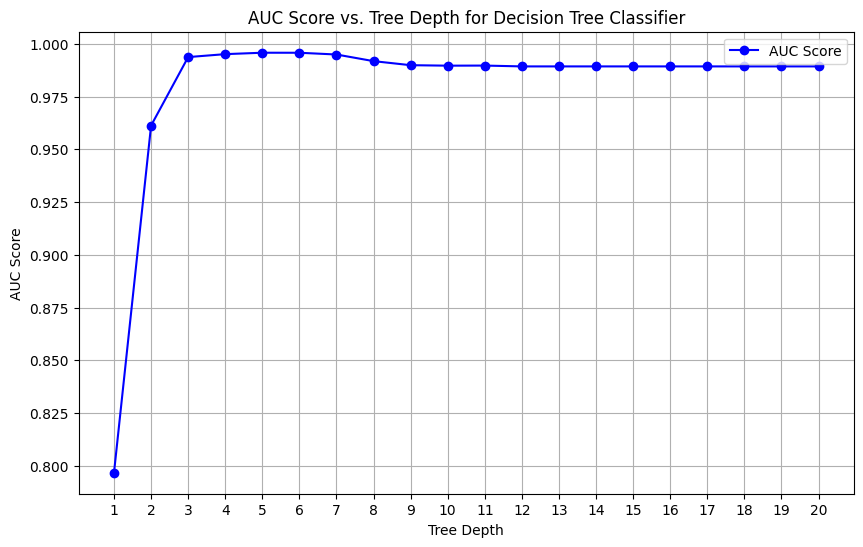

In [15]:
from sklearn.tree import DecisionTreeClassifier,export_text
from sklearn.metrics import accuracy_score

dv= DictVectorizer(sparse=True)
train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

auc_scores = []
depths = range(1, 21)
for max_depth in depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) 
    roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
    print("Decision Tree with depth " \
    f"{max_depth} Accuracy:", accuracy,"ROC AUC:", roc_auc)

    auc_scores.append(roc_auc)

# Plotting the AUC scores
plt.figure(figsize=(10, 6))
plt.plot(depths, auc_scores, marker='o', linestyle='-', color='b', label='AUC Score')
plt.xlabel('Tree Depth')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. Tree Depth for Decision Tree Classifier')
plt.grid(True)
plt.xticks(depths)  # Ensure we show all depth values on the x-axis
plt.legend()
plt.show()

Let's narrow down for  depth=4,5,6,7,8as the roc_auc is maximum(0.98) after which it decreases.

max_depth: 4, min_samples_leaf: 1, Accuracy: 0.9427662957074722, ROC AUC: 0.9950739552048358
max_depth: 4, min_samples_leaf: 2, Accuracy: 0.9427662957074722, ROC AUC: 0.9958325170696433
max_depth: 4, min_samples_leaf: 3, Accuracy: 0.9427662957074722, ROC AUC: 0.9958325170696433
max_depth: 4, min_samples_leaf: 4, Accuracy: 0.9427662957074722, ROC AUC: 0.9958325170696433
max_depth: 4, min_samples_leaf: 5, Accuracy: 0.9427662957074722, ROC AUC: 0.9957780217170469
max_depth: 4, min_samples_leaf: 10, Accuracy: 0.9427662957074722, ROC AUC: 0.9957259215802224
max_depth: 4, min_samples_leaf: 15, Accuracy: 0.9427662957074722, ROC AUC: 0.9957780217170469
max_depth: 4, min_samples_leaf: 20, Accuracy: 0.9427662957074722, ROC AUC: 0.9957780217170469
max_depth: 4, min_samples_leaf: 25, Accuracy: 0.9427662957074722, ROC AUC: 0.9957770652739143
max_depth: 4, min_samples_leaf: 50, Accuracy: 0.9427662957074722, ROC AUC: 0.9957665443994549
max_depth: 4, min_samples_leaf: 100, Accuracy: 0.9427662957074722

<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

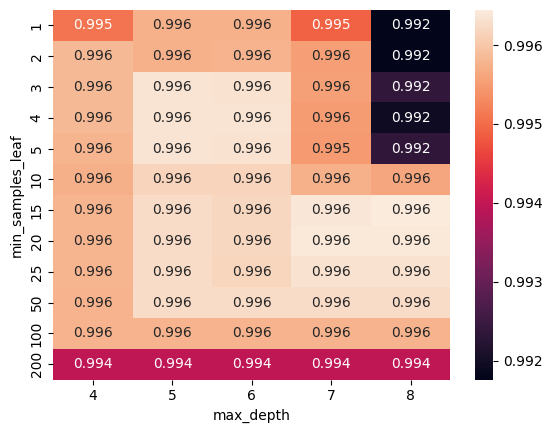

In [16]:
scores = []
for max_depth in [4,5, 6, 7, 8]:
    for min_samples_leaf in [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred) 
        roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
        scores.append({
            'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })
        print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}, Accuracy: {accuracy}, ROC AUC: {roc_auc}")
df_scores = pd.DataFrame(scores)
pivot_table = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='roc_auc')
sns.heatmap(pivot_table, annot=True, fmt=".3f") 

max_depth =6 and min_samples_leaf=3 roc_auc of 0.983.Lets test with test data to see if the model doesnt overfit.
We get the same results with test data as well.

In [17]:

dt = DecisionTreeClassifier(max_depth=6,min_samples_leaf=3, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
accuracy = accuracy_score(y_val, y_pred) 
roc_auc = roc_auc_score(y_val, dt.predict_proba(X_val), multi_class='ovr')
print("Decision Tree with validation data Accuracy:", accuracy,"ROC AUC:", roc_auc)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))
Model_ROC_AUC_scores.append(('Decision Tree', np.round(roc_auc,3)))
X_train.shape

Decision Tree with validation data Accuracy: 0.9507154213036566 ROC AUC: 0.9963335097413478
|--- tx_brate_downlink_mbps <= 0.23
|   |--- grant_ratio <= 0.74
|   |   |--- tx_brate_downlink_mbps <= 0.00
|   |   |   |--- dl_cqi <= 7.37
|   |   |   |   |--- dl_cqi <= 6.29
|   |   |   |   |   |--- dl_cqi <= 5.78
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |--- dl_cqi >  5.78
|   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- dl_cqi >  6.29
|   |   |   |   |   |--- dl_cqi <= 6.93
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- dl_cqi >  6.93
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- dl_cqi >  7.37
|   |   |   |   |--- dl_cqi <= 8.45
|   |   |   |   |   |--- dl_cqi <= 7.63
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- dl_cqi >  7.63
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- dl_cqi >  8.45
|   |   |   |   |   |--- dl_cqi <= 9.82
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- dl_cqi >  9.82
|   |

(3774, 12)

n_estimators: 10, Accuracy: 0.9491255961844197, ROC AUC: 0.9912347014632449
n_estimators: 20, Accuracy: 0.9427662957074722, ROC AUC: 0.9923017601426939
n_estimators: 30, Accuracy: 0.9451510333863276, ROC AUC: 0.9923422512580746
n_estimators: 40, Accuracy: 0.9459459459459459, ROC AUC: 0.9925377453292573
n_estimators: 50, Accuracy: 0.9459459459459459, ROC AUC: 0.9925416408015545
n_estimators: 60, Accuracy: 0.9459459459459459, ROC AUC: 0.9924483671881964
n_estimators: 70, Accuracy: 0.9435612082670907, ROC AUC: 0.9923700610091455
n_estimators: 80, Accuracy: 0.9459459459459459, ROC AUC: 0.9923119600218882
n_estimators: 90, Accuracy: 0.9459459459459459, ROC AUC: 0.992325254418807
n_estimators: 100, Accuracy: 0.9459459459459459, ROC AUC: 0.9922832674215503
n_estimators: 110, Accuracy: 0.9459459459459459, ROC AUC: 0.9921852166826776
n_estimators: 120, Accuracy: 0.9459459459459459, ROC AUC: 0.9925961199488226
n_estimators: 130, Accuracy: 0.9459459459459459, ROC AUC: 0.9926322541850668
n_estimat

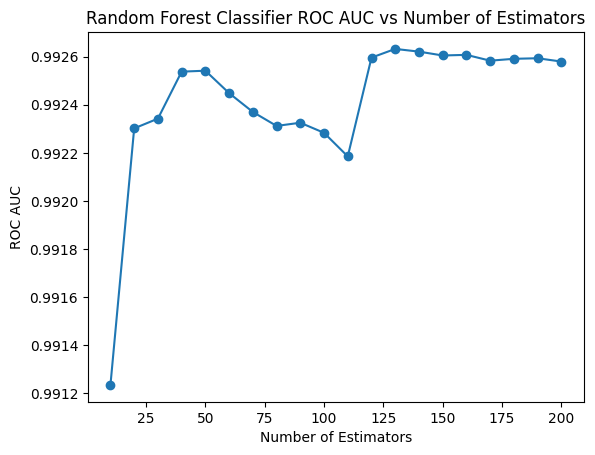

|--- tx_brate_downlink_mbps <= 0.23
|   |--- latency_proxy <= 8.14
|   |   |--- tx_brate_downlink_mbps <= 0.10
|   |   |   |--- prb_efficiency <= 0.00
|   |   |   |   |--- mcs_sinr_ratio <= 0.00
|   |   |   |   |   |--- ul_sinr <= 14.03
|   |   |   |   |   |   |--- dl_cqi <= 8.45
|   |   |   |   |   |   |   |--- ul_n_samples <= 12.00
|   |   |   |   |   |   |   |   |--- ul_n_samples <= 4.50
|   |   |   |   |   |   |   |   |   |--- ul_n_samples <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- dl_cqi <= 6.85
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- dl_cqi >  6.85
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |--- ul_n_samples >  1.50
|   |   |   |   |   |   |   |   |   |   |--- dl_cqi <= 6.92
|   |   |   |   |   |   |   |   |   |   |   |--- class: 2.0
|   |   |   |   |   |   |   |   |   |   |--- dl_cqi >  6.92
|   |   |   |   |   |   |  

In [18]:
from sklearn.ensemble import RandomForestClassifier

scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred) 
    roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val), multi_class='ovr')
    scores.append({
        'n_estimators': n,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    })
    print(f"n_estimators: {n}, Accuracy: {accuracy}, ROC AUC: {roc_auc}")
df_scores = pd.DataFrame(scores)
plt.plot(df_scores['n_estimators'], df_scores['roc_auc'], marker='o')
plt.xlabel('Number of Estimators')  
plt.ylabel('ROC AUC')
plt.title('Random Forest Classifier ROC AUC vs Number of Estimators')
plt.show()  
print(export_text(rf.estimators_[0], feature_names=list(dv.get_feature_names_out())))

With 50 estimators in ensemble model, we are able to get 0.987 roc_auc score

In [19]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

df_val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(df_val_dicts)
y_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred) 
roc_auc = roc_auc_score(y_val, rf.predict_proba(X_val), multi_class='ovr')
print("Random Forest with Validation Data Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))
Model_ROC_AUC_scores.append(('Random Forest', np.round(roc_auc, 3)))

df_test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(df_test_dicts)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
print("Random Forest with TestData Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))

Random Forest with Validation Data Accuracy: 0.946 ROC AUC: 0.993
Random Forest with TestData Accuracy: 0.957 ROC AUC: 0.994


In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# Basic XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Evaluate with cross-validation
scores = cross_val_score(xgb_model, X, y_fulltrain, cv=5, scoring='roc_auc_ovr')
print(f"XGBoost ROC-AUC: {scores.mean():.3f} (±{scores.std():.3f})")
Model_ROC_AUC_scores.append(("XGBoost", np.round(scores.mean(),3)))



XGBoost ROC-AUC: 0.997 (±0.001)


[('Logistic Regression', np.float64(0.965)), ('Decision Tree', np.float64(0.996)), ('Random Forest', np.float64(0.993)), ('XGBoost', np.float64(0.997))]


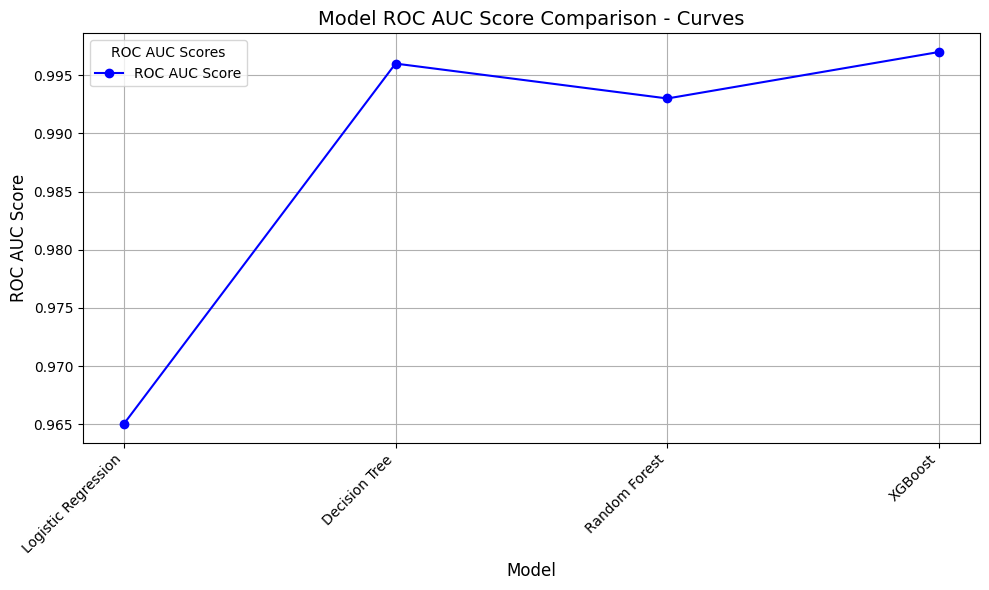

In [21]:
print(Model_ROC_AUC_scores)
Model, ROC_AUC_Score = zip(*Model_ROC_AUC_scores)
# Plotting the ROC AUC comparison using curves (line plot)
plt.figure(figsize=(10, 6))

# Plot the ROC AUC scores for each model
plt.plot(Model, ROC_AUC_Score, marker='o', linestyle='-', color='b', label='ROC AUC Score')

# Add labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('ROC AUC Score', fontsize=12)
plt.title('Model ROC AUC Score Comparison - Curves', fontsize=14)

# Add a legend to identify the line
plt.legend(title='ROC AUC Scores', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

From the graph it is clear that xgboost has the best performance and in network slicing even a small increase in performance can lead to a significant improvement in the overall system performance.
Let's finetune hyperparameters in XGBoost using GridSearch

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': randint(5, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 7),
    'gamma': uniform(0, 0.3)
}

random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42),
    param_dist,
    n_iter=100,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X, y_fulltrain)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")

# Use the best model
best_model = random_search.best_estimator_



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'colsample_bytree': np.float64(0.7130811315263301), 'gamma': np.float64(0.2983651532392023), 'learning_rate': np.float64(0.10398890279818859), 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 205, 'subsample': np.float64(0.8110476100766333)}
Best score: 0.9971


Through RandomSearchCV the best parameters are:
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'colsample_bytree': np.float64(0.7130811315263301), 'gamma': np.float64(0.2983651532392023), 'learning_rate': np.float64(0.10398890279818859), 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 205, 'subsample': np.float64(0.8110476100766333)}
Best score: 0.9971

In [23]:
best_model.fit(X, y_fulltrain)

df_test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(df_test_dicts)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
y_pred_proba=best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("XGBoost with TestData Accuracy:", np.round(accuracy, 3),"ROC AUC:", np.round(roc_auc, 3))
print_classification_report( y_pred,y_pred_proba,y_test)


XGBoost with TestData Accuracy: 0.964 ROC AUC: 0.997
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       405
           1       0.94      0.97      0.96       433
           2       0.99      0.95      0.97       420

    accuracy                           0.96      1258
   macro avg       0.96      0.96      0.96      1258
weighted avg       0.96      0.96      0.96      1258

*******************************************************
[[393  12   0]
 [  6 421   6]
 [  7  14 399]]
roc_auc score  0.9973147314713793
